In [1]:
# !pip install lime

In [23]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import explained_variance_score , mean_squared_error, r2_score

import psycopg2
import matplotlib. pyplot as plt 
import seaborn as sns

from collections import Counter
from config import password

In [3]:
# Load the pga data set dataset from database 
connection_string = f"host=red-team-final.c3yshvuxvm9x.us-east-2.rds.amazonaws.com dbname=red-team port=5432 user=postgres password={password}"
connection = psycopg2.connect(connection_string)

In [4]:
# Establish connection and db
sql = "select * from pga_stats"
pga_df = pd.read_sql(sql, connection)

In [5]:
# Show df
pga_df = pga_df.rename(columns={"money_MONEY":"Winnings"})
pga_df

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO,Winnings
0,1.144,2.099,321.1,66.80,51.47,0.696,66.67,80.34,80.87,50.25,...,48.89,61.27,0.435,41.01,3.27,1.752,28.74,14.54,1.84,5443091
1,0.841,1.700,307.1,64.01,29.17,0.582,72.11,85.90,83.80,57.32,...,50.00,63.07,-0.019,38.43,2.55,1.750,29.04,14.00,1.79,3556232
2,0.774,1.064,318.2,64.96,48.68,0.178,65.35,74.37,79.47,53.10,...,57.35,57.81,0.040,42.11,3.36,1.743,28.76,17.11,1.48,1782342
3,0.610,0.833,299.9,63.64,13.28,0.553,73.18,79.81,80.52,65.29,...,46.05,61.49,-0.013,37.67,2.52,1.756,29.30,12.50,1.91,1482028
4,0.567,0.563,287.4,60.36,8.33,-0.088,64.81,68.25,72.54,51.09,...,52.50,60.53,-0.793,39.12,2.78,1.779,29.25,15.74,1.15,164271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,-0.063,0.284,300.9,63.32,16.67,0.585,66.43,73.44,76.26,54.23,...,56.10,58.99,-0.113,36.55,3.22,1.807,29.45,16.26,1.17,824162
461,-0.417,-0.168,278.7,60.89,1.92,-0.006,63.53,68.20,73.63,48.14,...,54.17,62.30,0.451,42.02,1.42,1.748,28.32,15.03,1.27,942372
462,0.022,-0.402,285.1,62.05,1.69,-0.429,64.69,69.61,77.00,52.37,...,51.35,58.67,-0.006,38.51,2.73,1.779,29.15,16.95,1.14,332352
463,0.255,0.325,296.4,63.35,13.27,0.251,66.07,71.07,76.71,51.13,...,51.45,56.98,0.154,38.78,3.05,1.772,29.08,17.05,1.24,1943309


In [6]:
# Define the features set as everything but money 
X = pga_df.drop("Winnings", axis=1)
X.head()

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,SG_ATG_AVERAGE,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO
0,1.144,2.099,321.1,66.80,51.47,0.696,66.67,80.34,80.87,50.25,...,0.259,48.89,61.27,0.435,41.01,3.27,1.752,28.74,14.54,1.84
1,0.841,1.700,307.1,64.01,29.17,0.582,72.11,85.90,83.80,57.32,...,0.326,50.00,63.07,-0.019,38.43,2.55,1.750,29.04,14.00,1.79
2,0.774,1.064,318.2,64.96,48.68,0.178,65.35,74.37,79.47,53.10,...,0.112,57.35,57.81,0.040,42.11,3.36,1.743,28.76,17.11,1.48
3,0.610,0.833,299.9,63.64,13.28,0.553,73.18,79.81,80.52,65.29,...,-0.329,46.05,61.49,-0.013,37.67,2.52,1.756,29.30,12.50,1.91
4,0.567,0.563,287.4,60.36,8.33,-0.088,64.81,68.25,72.54,51.09,...,0.084,52.50,60.53,-0.793,39.12,2.78,1.779,29.25,15.74,1.15


In [7]:
# Define the target set as Money/ Earning PGA
y = pga_df[["Winnings"]]
y.head()

,Winnings
0,5443091
1,3556232
2,1782342
3,1482028
4,164271


C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


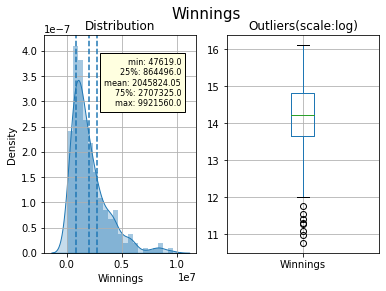

In [8]:
# Set variable
x = "Winnings"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=15)

# Distribution
ax[0].title.set_text('Distribution')
var = pga_df[x].fillna(pga_df[x].mean())
breaks = np.quantile(var, q=np.linspace(0, 1, 11))
var = var[ (var > breaks[0]) & (var < 
                    breaks[10]) ]
sns.distplot(var, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = pga_df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.9, 0.9, box, transform=ax[0].transAxes, fontsize=8, va='top', ha="right", bbox=dict(facecolor='lightyellow', alpha=1))

# Box plot 
ax[1].title.set_text('Outliers(scale:log)')
tmp_df = pd.DataFrame(pga_df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

<AxesSubplot:title={'center':'pearson correlation'}>

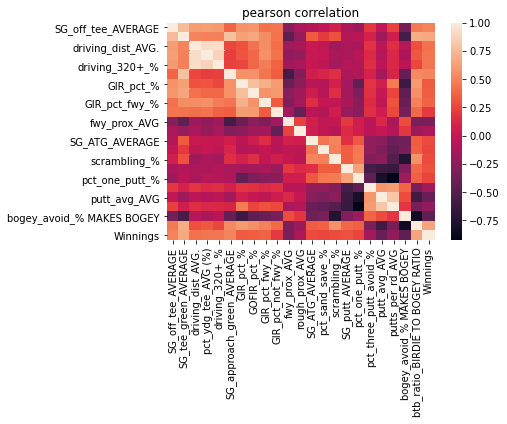

In [9]:
# Show correlation matrix
# Learned about pearson method from towarddatascience
c_matrix = pga_df.corr(method="pearson")
plt.title("pearson correlation")
sns.heatmap(c_matrix)

In [10]:
# Split Data into testing and training 
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(Counter(y_train))
print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("y_train mean:", round(np.mean(y_train),2), "| y_test mean:", round(np.mean(y_test),2))

Counter({'Winnings': 1})
X_train shape: (348, 22) | X_test shape: (117, 22)
y_train mean: Winnings    2079243.07
dtype: float64 | y_test mean: Winnings    1946423.88
dtype: float64


In [80]:
# Create a scaler instance
scaler = StandardScaler()

# Fit
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [81]:
# Call Linear Regression model
model = linear_model.LinearRegression()

# Train data to model
model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# Predict
y_pred = model.predict(X_test_scaled)
y_pred

Feature: 0, Score: 226112.61847
Feature: 1, Score: 319122.27758
Feature: 2, Score: -525704.50319
Feature: 3, Score: 492309.01424
Feature: 4, Score: 311930.49841
Feature: 5, Score: 438211.26060
Feature: 6, Score: -515315.75535
Feature: 7, Score: -252872.98002
Feature: 8, Score: 31906.10483
Feature: 9, Score: 50143.48927
Feature: 10, Score: -83347.36951
Feature: 11, Score: 45079.46984
Feature: 12, Score: 192813.56354
Feature: 13, Score: -16529.79104
Feature: 14, Score: 180705.81871
Feature: 15, Score: 536039.64811
Feature: 16, Score: -478939.81782
Feature: 17, Score: -4457.49878
Feature: 18, Score: -135069.40984
Feature: 19, Score: 224528.09955
Feature: 20, Score: 511242.01377
Feature: 21, Score: 1174367.59829


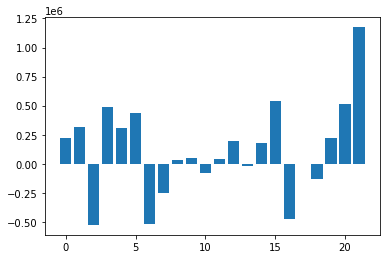

,Coefficients
Feature,
btb_ratio_BIRDIE TO BOGEY RATIO,1.174368e+06
SG_putt_AVERAGE,5.360396e+05
bogey_avoid_% MAKES BOGEY,5.112420e+05
pct_ydg_tee_AVG (%),4.923090e+05
SG_approach_green_AVERAGE,4.382113e+05
SG_tee_green_AVERAGE,3.191223e+05
driving_320+_%,3.119305e+05
SG_off_tee_AVERAGE,2.261126e+05
putts_per_rd_AVG,2.245281e+05


In [102]:
# Get feature importance
importance = model.coef_
importance = np.ravel(importance)

# Explore features
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefficients",model.coef_.transpose())
coef_table = coef_table.rename(columns={0: "Feature"}).set_index("Feature")

# Summarize importance
for r, c in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (r,c))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

sorted_feature_table = coef_table.sort_values(by=["Coefficients"], ascending=False)
sorted_feature_table

In [108]:
# Show variance
explained_variance_score(y_test, y_pred)

0.5973325810962058

In [107]:
# MSE
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# Coefficient of determination (should match explained variance)
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 1043279932089.91
Coefficient of determination: 0.59
